# **🏥 Breast Cancer Detection using PyTorch**

### A Step-by-Step Deep Learning Pipeline

**Goal:** Build a Neural Network to predict if a tumor is **Malignant (Cancerous)** or **Benign (Safe)**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import torch

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

### **1. Data Loading & Cleaning**
- **Objective:** Get the raw data into a clean, usable format.
- **Action:** Drop useless columns like 'id' that don't help prediction.

In [58]:
# Using Breast Cancer Detection Dataset

df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [59]:
df.shape

(569, 33)

- Remove 'id' (just a label) and 'Unnamed: 32' (an empty error column often found in CSVs)
- axis=1 means we are dropping COLUMNS, not rows.

In [60]:
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

### Visualizing Data Distribution

/tmp/ipython-input-712612407.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='viridis')


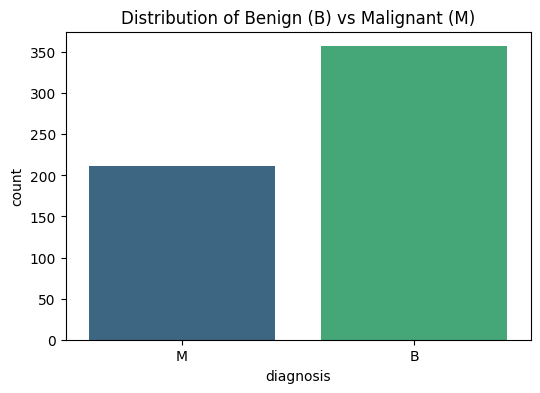

In [61]:

# 1. Target Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Distribution of Benign (B) vs Malignant (M)')
plt.show()

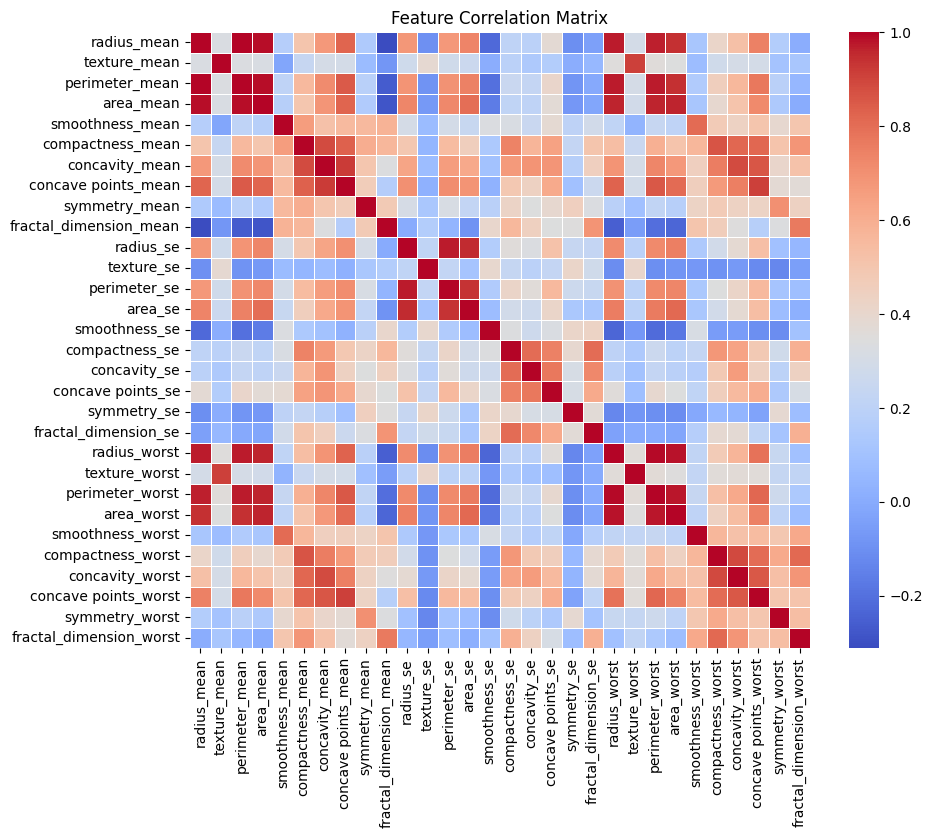

In [62]:
# 2. Correlation Matrix
plt.figure(figsize=(10, 8))
# We only use numeric columns for correlation
numeric_df = df.iloc[:, 1:] 
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [63]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### **2. Train-Test Split**
-  **Concept:** We must hide some data from the model to test it later.
-  **Why?** If the model memorizes the answers (Overfitting), it will fail in the real world.
-  **Split:** 80% for Training (Studying), 20% for Testing (Final Exam).

* X = Features (All columns starting from index 1)
* y = Target (The first column, usually 'diagnosis')

In [64]:
# Splitting the dataset into features and target variable
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size=0.2)

## **3. Feature Scaling**
* **Concept:** Making all numbers roughly the same size.
* **Why?** The dataset has 'Area' (1000+) and 'Smoothness' (0.01). Without scaling, the model will think 'Area' is more important just because the number is bigger.
* **Rule:** Always `fit` on Train, and only `transform` on Test (to avoid cheating/data leakage).

In [65]:
# scalar object
scaler = StandardScaler()

# 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
X_train

array([[ 0.14047285, -0.93075576,  0.14855534, ...,  0.36692026,
         0.40432704,  0.02250378],
       [ 1.91690183,  0.3100109 ,  1.83468778, ...,  1.7063254 ,
        -1.03820036, -0.55910614],
       [-0.71749285, -1.0036038 , -0.72378816, ..., -0.29474284,
        -0.39126848, -0.34599716],
       ...,
       [-0.76699088, -0.13882704, -0.76800283, ..., -0.45644226,
         0.2556634 , -0.91539771],
       [-0.82473857,  0.76119877, -0.81859079, ..., -0.77938604,
         0.43373303, -0.22223856],
       [-0.57174868, -1.0741019 , -0.5576844 , ..., -0.75890816,
        -0.25567417, -0.07295128]])

In [67]:
y_train

,diagnosis
89,B
449,M
249,B
206,B
328,M
...,...
58,B
225,B
515,B
551,B


### **4. Label Encoding**
* **Concept:** Computers can't read text like "M" (Malignant) or "B" (Benign).
* **Action:** Convert them to numbers: M -> 1, B -> 0.

In [68]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [69]:
# Check the result (Should be an array of 0s and 1s now)
print("Encoded Labels sample:", y_train[:5])

Encoded Labels sample: [0 1 0 0 1]


### **5. Convert to PyTorch Tensors**
* **Concept:** PyTorch doesn't understand NumPy arrays; it speaks "Tensors."
* **Important Fixes:** 
    *  `.float()`: Neural networks need 32-bit floats (standard), not 64-bit doubles.
    *  `.unsqueeze(1)`: Reshapes `y` from a flat list `[1, 0, 1]` to a column vector `[[1], [0], [1]]`. This is crucial for matching the output shape of the model later!

In [70]:
# Converting numpy arrays to torch tensors
# Convert X (Features)

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

# Convert y (Targets) and fix the shape
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

In [71]:
X_train_tensor.shape
print(X_train_tensor)

tensor([[ 0.1405, -0.9308,  0.1486,  ...,  0.3669,  0.4043,  0.0225],
        [ 1.9169,  0.3100,  1.8347,  ...,  1.7063, -1.0382, -0.5591],
        [-0.7175, -1.0036, -0.7238,  ..., -0.2947, -0.3913, -0.3460],
        ...,
        [-0.7670, -0.1388, -0.7680,  ..., -0.4564,  0.2557, -0.9154],
        [-0.8247,  0.7612, -0.8186,  ..., -0.7794,  0.4337, -0.2222],
        [-0.5717, -1.0741, -0.5577,  ..., -0.7589, -0.2557, -0.0730]])


In [ ]:
y_train_tensor.shape
print(f"Shapes verified: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

Shapes verified: X=torch.Size([455, 30]), y=torch.Size([455, 1])


### **6. Define the Neural Network Architecture**
 * **`nn.Module`**: The blueprint for all PyTorch models.
 * **`nn.Linear`**: A standard Dense layer. Connects every input to every output.
 * **`nn.ReLU`**: The "Activation Function." It allows the model to learn complex, curvy patterns (not just straight lines).
* **`nn.Sigmoid`**: The "Probability Function." Squishes the final output between 0 and 1. Perfect for Yes/No questions.

In [ ]:
# Create Model Class
import torch.nn as nn

# nn.Module as a blueprint provided by PyTorch. 
# By saying class NeuralNet(nn.Module), we are telling python to use all the super powers of PyTorch's nn.Module class.
class NeuralNet(nn.Module):
    
    def __init__(self, num_features):
        super().__init__() # <--- The "Boilerpalte" line.

        # This is the "Stack of Layers" that we will use in our Neural Network.
        # (Pipe)Sequential is a container that allows us to stack layers together.
        self.network = nn.Sequential(

            # Layer 1 : The input layer -> hidden layer
            nn.Linear(num_features, 16),

            # Layer 1 : The "Spark" : The activation function introduces non-linearity to the model.
            nn.ReLU(),

            # Layer 2 : The hidden layer -> output layer
            nn.Linear(16, 8),
            nn.ReLU(),

            # Layer 3 : The output layer
            nn.Linear(8, 1),
            # The "Squish" : The activation function for output layer to convert it to probability.
            nn.Sigmoid()
        )

    # 
    def forward(self, features):
        out = self.network(features) # <--- Pass data through the pipe we made above
        return out

### **7. Initialize Model, Loss, and Optimizer**
* **Model:** We create an instance of our class.
* **Criterion (Loss Function):** `BCELoss` (Binary Cross Entropy). The standard "Scorecard" for Yes/No classification.
* **Optimizer:** `Adam`. The "Teacher" that updates the weights. It's generally faster and smarter than standard SGD.

In [74]:
# create dataset
features = X_train_tensor

# Create model
model = NeuralNet(features.shape[1])

## call the model for forward pass
# model.forward(features)
prediction = model(features)

In [75]:
# show model weights
model.network[0].weight

Parameter containing:
tensor([[-1.1156e-01, -6.9619e-02, -9.4600e-02, -1.7671e-01, -8.0521e-02,
         -6.7226e-02,  1.2058e-01, -7.7067e-02,  1.6057e-01, -5.7463e-04,
          1.4554e-01, -1.4573e-01, -5.2940e-02, -1.2904e-01, -8.8576e-02,
          1.1839e-02, -3.8404e-02,  1.5033e-03,  3.4964e-02, -3.8964e-02,
          1.6091e-01,  1.1633e-01,  1.6937e-01,  1.1902e-01, -1.2388e-01,
         -6.7297e-02,  2.3034e-02, -8.5907e-02, -7.6312e-02, -1.0667e-01],
        [-7.3001e-02, -3.8159e-02,  4.9066e-03,  1.5253e-01, -1.3157e-01,
          1.7245e-01,  6.7822e-02, -8.7316e-02, -1.3579e-01, -1.4353e-01,
          1.4372e-01,  3.9511e-03,  6.7662e-02, -1.7785e-01, -1.5115e-01,
          7.8175e-02, -1.3347e-01,  1.7319e-01,  3.7889e-02,  1.6227e-01,
          1.7581e-01, -1.0712e-01, -3.3133e-02, -1.1518e-02, -1.2930e-02,
         -1.0961e-01, -1.2799e-01, -9.3761e-02,  2.4058e-02,  1.1930e-01],
        [-1.4701e-01,  2.2087e-02,  1.2205e-01, -7.7545e-02,  1.0649e-01,
          1.55

In [76]:
# Calculating loss (The scoreboard) 
# "BCELoss" stands for Binary Cross Entropy !
criterion = nn.BCELoss()

# this will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# calcualte loss using the criterion
loss = criterion(prediction,  y_train_tensor)

# backpropagation
loss.backward()
optimizer.step()

The Trainigng Loop (The learning Phase)

### **8. The Training Loop (Where Learning Happens)**
- This is the heart of Deep Learning. We repeat this cycle 100 times (Epochs). 
1.  **Forward:** Model guesses.
2.  **Loss:** We check how wrong the guess was.
3.  **Zero Grad:** Clear old calculations.
4.  **Backward:** Calculate who is to blame for the error (Gradients).
5.  **Step:** Update weights to fix the error.

In [ ]:
loss_values = []
train_acc_values = []
test_acc_values = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    y_pred = model(features)

    # Calculate loss
    loss = criterion(y_pred, y_train_tensor)
    loss_values.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track accuracy on train and test sets
    with torch.no_grad():
        model.eval()
        train_pred = model(features)
        train_acc = (train_pred.round().eq(y_train_tensor).sum().item()) / y_train_tensor.shape[0]
        test_pred = model(X_test_tensor)
        test_acc = (test_pred.round().eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
        train_acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        model.train()


    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%')


Epoch [10/100], Loss: 0.2522, Train Acc: 94.95%, Test Acc: 91.23%
Epoch [20/100], Loss: 0.0883, Train Acc: 97.58%, Test Acc: 94.74%
Epoch [30/100], Loss: 0.0612, Train Acc: 98.02%, Test Acc: 95.61%
Epoch [40/100], Loss: 0.0490, Train Acc: 98.46%, Test Acc: 95.61%
Epoch [50/100], Loss: 0.0401, Train Acc: 98.68%, Test Acc: 96.49%
Epoch [60/100], Loss: 0.0333, Train Acc: 98.90%, Test Acc: 96.49%
Epoch [70/100], Loss: 0.0273, Train Acc: 99.34%, Test Acc: 96.49%
Epoch [80/100], Loss: 0.0219, Train Acc: 99.34%, Test Acc: 96.49%
Epoch [90/100], Loss: 0.0171, Train Acc: 99.56%, Test Acc: 94.74%
Epoch [100/100], Loss: 0.0132, Train Acc: 99.56%, Test Acc: 94.74%


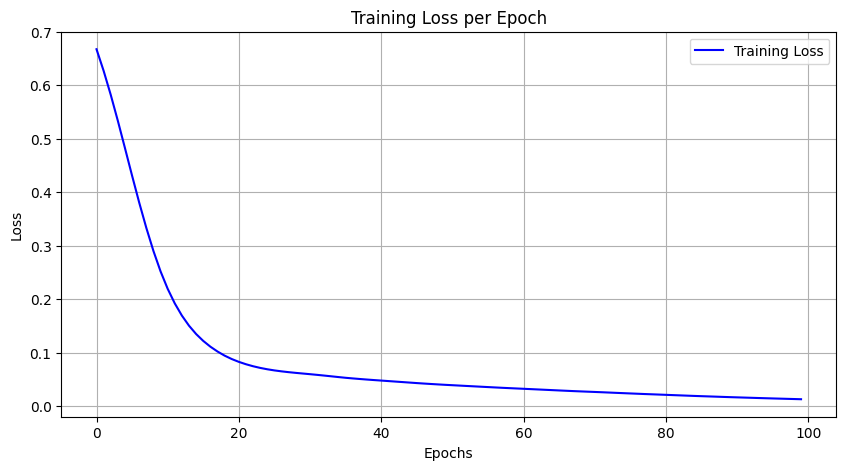

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

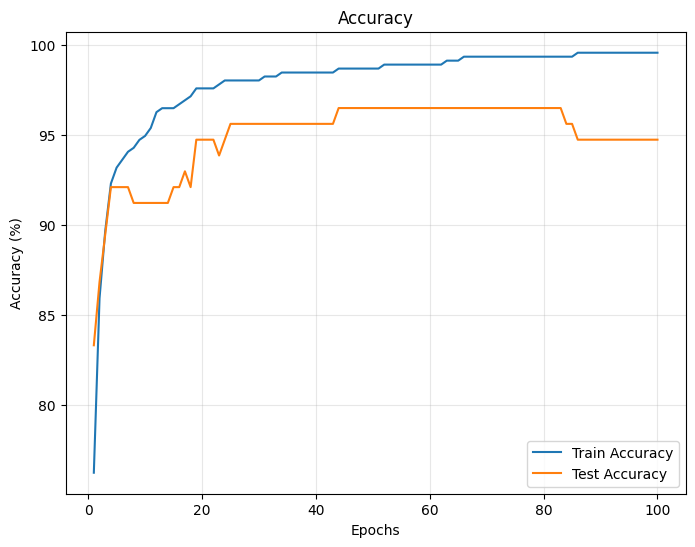

In [79]:
plt.figure(figsize=(8, 6))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, [acc * 100 for acc in train_acc_values], label='Train Accuracy')

plt.plot(epochs, [acc * 100 for acc in test_acc_values], label='Test Accuracy')

plt.title('Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy (%)')

plt.grid(True, alpha=0.3)

plt.legend()

plt.show()


### **9. Evaluation (The Final Exam)**
* **`model.eval()`**: Tells PyTorch "We are testing now." (Turns off training-specific features like Dropout).
* **`torch.no_grad()`**: Tells PyTorch "Don't calculate gradients." (Saves memory and speed since we aren't learning anymore).

In [80]:
model.eval()  # set the model to evaluation mode

with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_cls = y_test_pred.round()  # Convert probabilities to 0 or 1
    accuracy = (y_test_pred_cls.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.74%


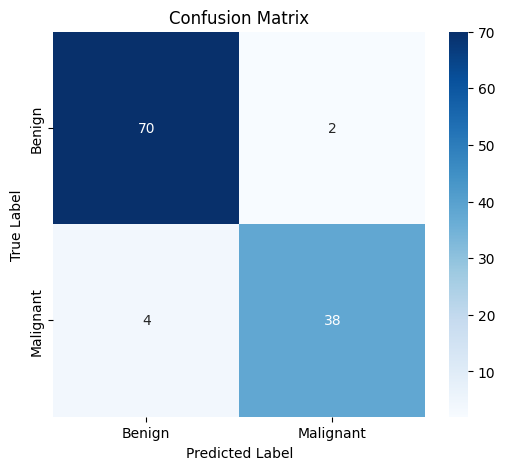

In [81]:
# %%
from sklearn.metrics import confusion_matrix

# Ensure we are in eval mode
model.eval()

# Generate predictions again for the confusion matrix
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_cls = y_test_pred.round() 

# Convert tensors to numpy arrays
y_true = y_test_tensor.numpy()
y_pred = y_test_pred_cls.numpy()

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [82]:
%pip install torchinfo

### **10. Model Summary**
- Visualizing the layers and parameter counts.

In [83]:
from torchinfo import summary

# input_size format: (batch_size, num_features)
# Your dataset has 30 features, so use (1, 30) for a single sample
summary(model, input_size=(1, 30))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 16]                   496
│    └─ReLU: 2-2                         [1, 16]                   --
│    └─Linear: 2-3                       [1, 8]                    136
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 1]                    9
│    └─Sigmoid: 2-6                      [1, 1]                    --
Total params: 641
Trainable params: 641
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00